<a href="https://colab.research.google.com/github/HassanFrazKhan/Barclays-Stock-Price-Prediction-Using-Advanced-ML-/blob/main/Barclays_stock_Pred_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Necessary Libraries:**

Ensure you have the required libraries installed:

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
from datetime import date
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric





#**Fetching Barclays Stock Data:**
 New section
 The ticker symbol for Barclays on the London Stock Exchange is BARC.L.

In [ ]:
# Download Barclays Stock Data
# Define the ticker symbol
ticker_symbol = 'BARC.L'


# Define the date range
start_date = '2014-01-01'
end_date = date.today().strftime('%Y-%m-%d')

# Download historical stock data
barclays_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')

# Ensure the data is sorted by date
barclays_data.sort_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


#**Calculating Technical Indicators:**

We'll compute the following features using past data (shifted by one day to prevent data leakage):

Moving Averages: 5-day, 10-day, and 50-day moving averages of the closing price.


Daily Returns: Percentage change in the closing price from the previous day.


Volatility: Rolling standard deviation of daily returns over a 10-day window.

In [ ]:
# Calculate moving averages (shifted by 1 day)
barclays_data['MA_5'] = barclays_data['Close'].rolling(window=5).mean().shift(1)
barclays_data['MA_10'] = barclays_data['Close'].rolling(window=10).mean().shift(1)
barclays_data['MA_50'] = barclays_data['Close'].rolling(window=50).mean().shift(1)

# Calculate daily returns (shifted by 1 day)
barclays_data['Daily_Returns'] = barclays_data['Close'].pct_change().shift(1) * 100

# Calculate volatility (rolling standard deviation of returns, shifted by 1 day)
barclays_data['Volatility'] = barclays_data['Daily_Returns'].rolling(window=10).std().shift(1)

# Drop rows with NaN values resulting from rolling calculations
barclays_data.dropna(inplace=True)



**Defining Features and Target Variable:**
We'll define our feature set (X) and target variable (y):

In [ ]:
# Define features (X) and target variable (y)
X = barclays_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y = barclays_data['Close']


#**Splitting the Data into Training and Testing Sets:**

We'll split the data based on time to create training and testing datasets:

In [ ]:
# Split data into training and testing sets
train_data = barclays_data[barclays_data.index < '2023-01-01']
test_data = barclays_data[barclays_data.index >= '2023-01-01']

X_train = train_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y_train = train_data['Close']
X_test = test_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y_test = test_data['Close']

Saving the Datasets to CSV Files:

Finally, we'll save the datasets to CSV files for future use:

In [ ]:
# Save datasets to CSV files
train_data.to_csv("barclays_train_data.csv")
test_data.to_csv("barclays_test_data.csv")
X_train.to_csv("barclays_train_features.csv")
y_train.to_csv("barclays_train_target.csv")
X_test.to_csv("barclays_test_features.csv")
y_test.to_csv("barclays_test_target.csv")

In [ ]:
# Printing the total number of days and features in the dataset
print('Total number of days present in the dataset:', barclays_data.shape[0])
print('Total number of fields present in the dataset:', barclays_data.shape[1])

Total number of days present in the dataset: 2761
Total number of fields present in the dataset: 10


In [ ]:
# Checking the null values
print('Null Values:',barclays_data.isnull().values.sum())
print('NA values:',barclays_data.isnull().values.any())

Null Values: 0
NA values: False


In [ ]:
barclays_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2761 entries, 2014-03-13 to 2025-02-14
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BARC.L)    2761 non-null   float64
 1   (High, BARC.L)     2761 non-null   float64
 2   (Low, BARC.L)      2761 non-null   float64
 3   (Open, BARC.L)     2761 non-null   float64
 4   (Volume, BARC.L)   2761 non-null   int64  
 5   (MA_5, )           2761 non-null   float64
 6   (MA_10, )          2761 non-null   float64
 7   (MA_50, )          2761 non-null   float64
 8   (Daily_Returns, )  2761 non-null   float64
 9   (Volatility, )     2761 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 237.3 KB


In [ ]:
barclays_data.head()

Price,Close,High,Low,Open,Volume,MA_5,MA_10,MA_50,Daily_Returns,Volatility
Ticker,BARC.L,BARC.L,BARC.L,BARC.L,BARC.L,,,,,
Date,,,,,,,,,,
2014-03-13,176.052338,179.563681,175.529375,175.940278,64888340,181.326801,184.726071,197.551641,-1.016316,1.490307
2014-03-14,172.690384,178.293576,170.552958,176.014954,73837468,178.689566,183.362630,197.076948,0.812845,1.452711
2014-03-17,172.615723,174.570867,171.793916,173.400172,46130614,176.119556,181.797467,196.508480,-1.909633,1.503706
2014-03-18,176.351166,177.807994,171.980671,173.176023,57727630,174.483435,180.542352,195.869971,-0.043234,1.548836
2014-03-19,180.422836,181.767605,173.449475,178.181559,64501431,174.468491,179.279767,195.255311,2.164023,1.537761


**Flatten the MultiIndex Columns:**

First, we'll flatten the MultiIndex columns to simplify the DataFrame structure.

In [ ]:
# Flatten MultiIndex columns
barclays_data.columns = ['_'.join(filter(None, col)).strip() for col in barclays_data.columns.values]

# Display the updated columns
print(barclays_data.columns)


Index(['Close_BARC.L', 'High_BARC.L', 'Low_BARC.L', 'Open_BARC.L',
       'Volume_BARC.L', 'MA_5', 'MA_10', 'MA_50', 'Daily_Returns',
       'Volatility'],
      dtype='object')


Resample the Data:

Next, we'll resample the data to weekly, monthly, and yearly frequencies. For each period, we'll compute the opening price (first value), closing price (last value), highest price, lowest price, and total volume.

In [ ]:
# Resample to weekly frequency
barclays_weekly = barclays_data.resample('W').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})

# Resample to monthly frequency
barclays_monthly = barclays_data.resample('M').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})

# Resample to yearly frequency
barclays_yearly = barclays_data.resample('A').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})


<ipython-input-223-7bafb0debb45>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  barclays_monthly = barclays_data.resample('M').agg({
<ipython-input-223-7bafb0debb45>:20: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  barclays_yearly = barclays_data.resample('A').agg({


# **Plot the Data:**

We'll create subplots to visualize the open and closing prices for daily, weekly, monthly, and yearly data.

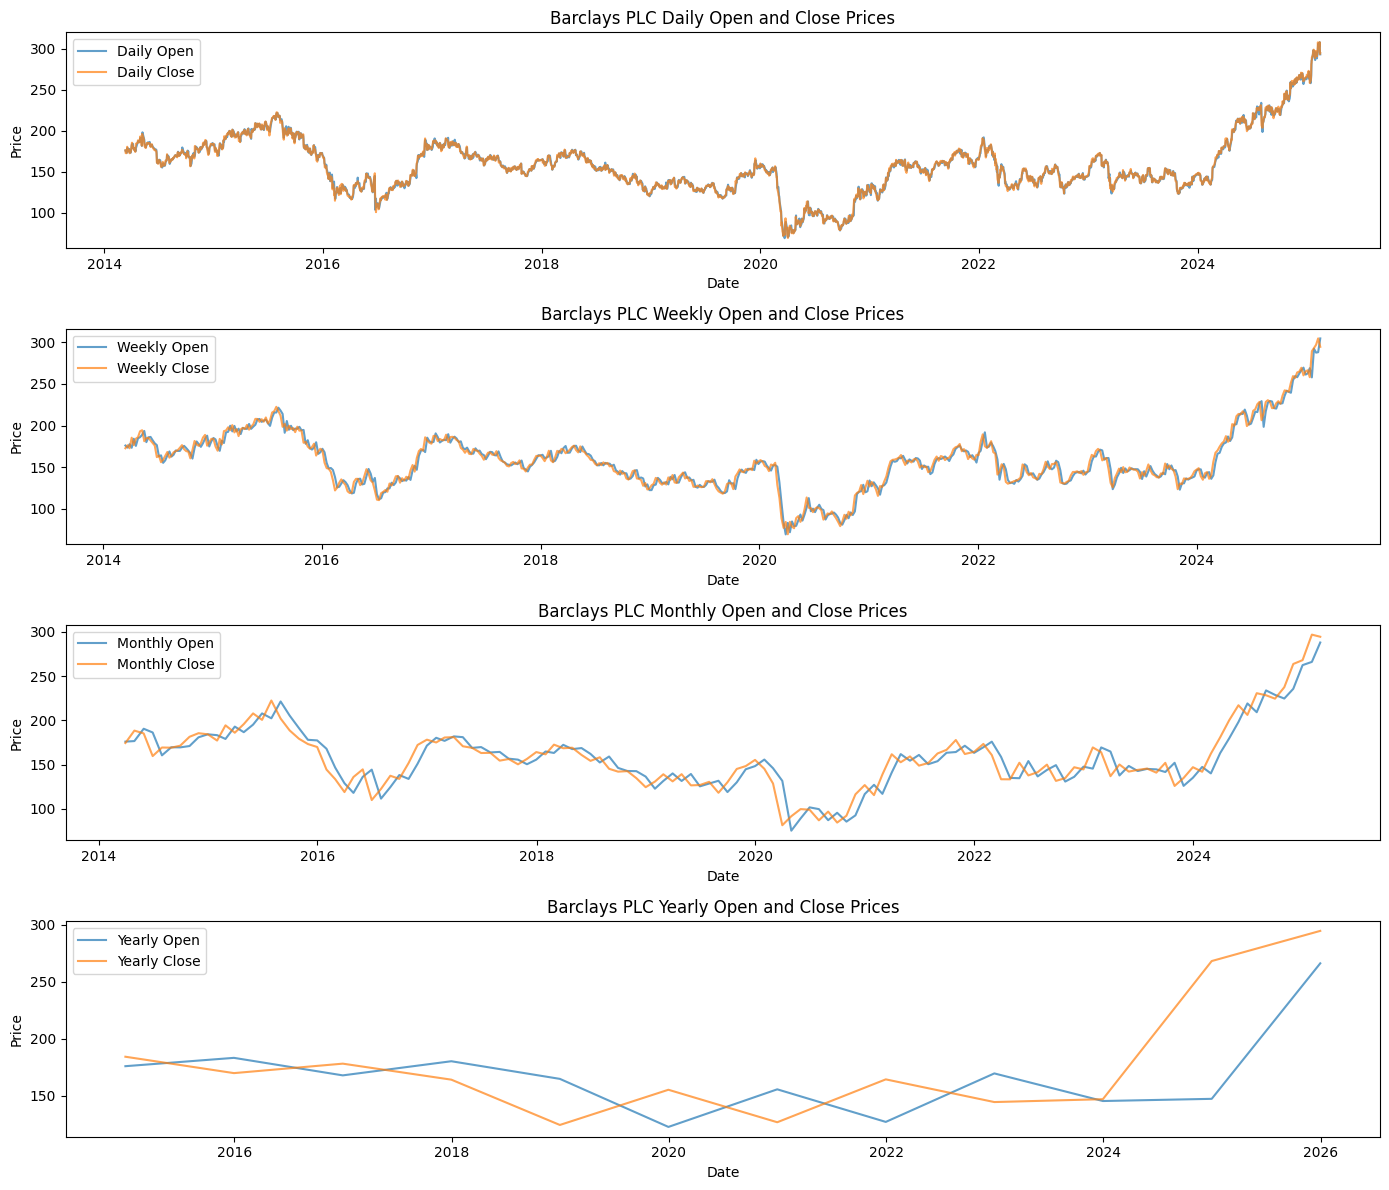

In [ ]:

plt.figure(figsize=(14, 12))

# Daily Open and Close Prices
plt.subplot(4, 1, 1)
plt.plot(barclays_data.index, barclays_data['Open_BARC.L'], label='Daily Open', alpha=0.7)
plt.plot(barclays_data.index, barclays_data['Close_BARC.L'], label='Daily Close', alpha=0.7)
plt.title('Barclays PLC Daily Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Weekly Open and Close Prices
plt.subplot(4, 1, 2)
plt.plot(barclays_weekly.index, barclays_weekly['Open_BARC.L'], label='Weekly Open', alpha=0.7)
plt.plot(barclays_weekly.index, barclays_weekly['Close_BARC.L'], label='Weekly Close', alpha=0.7)
plt.title('Barclays PLC Weekly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Monthly Open and Close Prices
plt.subplot(4, 1, 3)
plt.plot(barclays_monthly.index, barclays_monthly['Open_BARC.L'], label='Monthly Open', alpha=0.7)
plt.plot(barclays_monthly.index, barclays_monthly['Close_BARC.L'], label='Monthly Close', alpha=0.7)
plt.title('Barclays PLC Monthly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Yearly Open and Close Prices
plt.subplot(4, 1, 4)
plt.plot(barclays_yearly.index, barclays_yearly['Open_BARC.L'], label='Yearly Open', alpha=0.7)
plt.plot(barclays_yearly.index, barclays_yearly['Close_BARC.L'], label='Yearly Close', alpha=0.7)
plt.title('Barclays PLC Yearly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


# **LSTM Model**

In [ ]:
# Utility function to create dataset
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
future_steps = 30


# Forecasting CLOSE Price LSTM Model

In [ ]:
# Scale the Close price
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_close.fit_transform(barclays_data['Close_BARC.L'].values.reshape(-1, 1))

# Create dataset for Close price
X_close, Y_close = create_dataset(scaled_close, time_step)
X_close = X_close.reshape(X_close.shape[0], X_close.shape[1], 1)

# Split data into training and testing sets for Close price
train_size_close = int(len(X_close) * 0.8)
X_train_close, X_test_close = X_close[:train_size_close], X_close[train_size_close:]
Y_train_close, Y_test_close = Y_close[:train_size_close], Y_close[train_size_close:]

# Build LSTM model for Close price
lstm_model_close = Sequential()
lstm_model_close.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model_close.add(LSTM(50, return_sequences=False))
lstm_model_close.add(Dense(25))
lstm_model_close.add(Dense(1))
lstm_model_close.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_close.fit(X_train_close, Y_train_close, batch_size=1, epochs=1)

# Forecast future 30 days for Close price (recursive forecasting)
last_window_close = scaled_close[-time_step:]
temp_input_close = list(last_window_close.flatten())
lst_output_close = []
for i in range(future_steps):
    x_input_close = np.array(temp_input_close[-time_step:]).reshape(1, time_step, 1)
    yhat_close = lstm_model_close.predict(x_input_close, verbose=0)
    lst_output_close.append(yhat_close[0][0])
    temp_input_close.append(yhat_close[0][0])
future_predictions_close = scaler_close.inverse_transform(np.array(lst_output_close).reshape(-1, 1))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2128/2128 ━━━━━━━━━━━━━━━━━━━━ 110s 50ms/step - loss: 0.0019


# Forecasting OPEN Price for LSTM Model

In [ ]:
# Scale the Open price
scaler_open = MinMaxScaler(feature_range=(0, 1))
scaled_open = scaler_open.fit_transform(barclays_data['Open_BARC.L'].values.reshape(-1, 1))

# Create dataset for Open price
X_open, Y_open = create_dataset(scaled_open, time_step)
X_open = X_open.reshape(X_open.shape[0], X_open.shape[1], 1)

# Split data into training and testing sets for Open price
train_size_open = int(len(X_open) * 0.8)
X_train_open, X_test_open = X_open[:train_size_open], X_open[train_size_open:]
Y_train_open, Y_test_open = Y_open[:train_size_open], Y_open[train_size_open:]

# Build LSTM model for Open price
lstm_model_open = Sequential()
lstm_model_open.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model_open.add(LSTM(50, return_sequences=False))
lstm_model_open.add(Dense(25))
lstm_model_open.add(Dense(1))
lstm_model_open.compile(optimizer='adam', loss='mean_squared_error')
lstm_model_open.fit(X_train_open, Y_train_open, batch_size=1, epochs=1)

# Forecast future 30 days for Open price (recursive forecasting)
last_window_open = scaled_open[-time_step:]
temp_input_open = list(last_window_open.flatten())
lst_output_open = []
for i in range(future_steps):
    x_input_open = np.array(temp_input_open[-time_step:]).reshape(1, time_step, 1)
    yhat_open = lstm_model_open.predict(x_input_open, verbose=0)
    lst_output_open.append(yhat_open[0][0])
    temp_input_open.append(yhat_open[0][0])
future_predictions_open = scaler_open.inverse_transform(np.array(lst_output_open).reshape(-1, 1))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2128/2128 ━━━━━━━━━━━━━━━━━━━━ 107s 49ms/step - loss: 0.0034



# 30 Days Combine Future Predictions in a DataFrame for LSTM


In [ ]:
# Generate future dates (using the last available date from barclays_data)
# last_date = pd.to_datetime(barclays_data['Date'].iloc[-1])  # Original line causing error

# Assuming 'Date' was flattened to 'Date_' or used as index:
# Check if 'Date_' exists:
if 'Date_' in barclays_data.columns:
    last_date = pd.to_datetime(barclays_data['Date_'].iloc[-1])
# Otherwise, assume 'Date' was used as index:
else:
    last_date = barclays_data.index[-1]

future_dates = [last_date + pd.DateOffset(days=i+1) for i in range(future_steps)]

# Create a DataFrame with predicted Open and Close prices
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Open': future_predictions_open.flatten(),
    'Predicted Close': future_predictions_close.flatten()
})

print("Future 30-day Predictions (Open & Close):")
print(future_df)

Future 30-day Predictions (Open & Close):
         Date  Predicted Open  Predicted Close
0  2025-02-15      283.918884       293.715027
1  2025-02-16      278.541046       290.973541
2  2025-02-17      272.497894       288.387665
3  2025-02-18      266.283600       285.879669
4  2025-02-19      260.143585       283.438751
5  2025-02-20      254.207092       281.069336
6  2025-02-21      248.543961       278.776764
7  2025-02-22      243.189392       276.563324
8  2025-02-23      238.156479       274.428558
9  2025-02-24      233.443497       272.369202
10 2025-02-25      229.038284       270.380463
11 2025-02-26      224.922165       268.456360
12 2025-02-27      221.072281       266.590332
13 2025-02-28      217.463974       264.775848
14 2025-03-01      214.072327       263.006378
15 2025-03-02      210.873398       261.275879
16 2025-03-03      207.844971       259.578857
17 2025-03-04      204.967148       257.910400
18 2025-03-05      202.222565       256.266235
19 2025-03-06     


#  30 Days Plot Future Predictions for LSTM


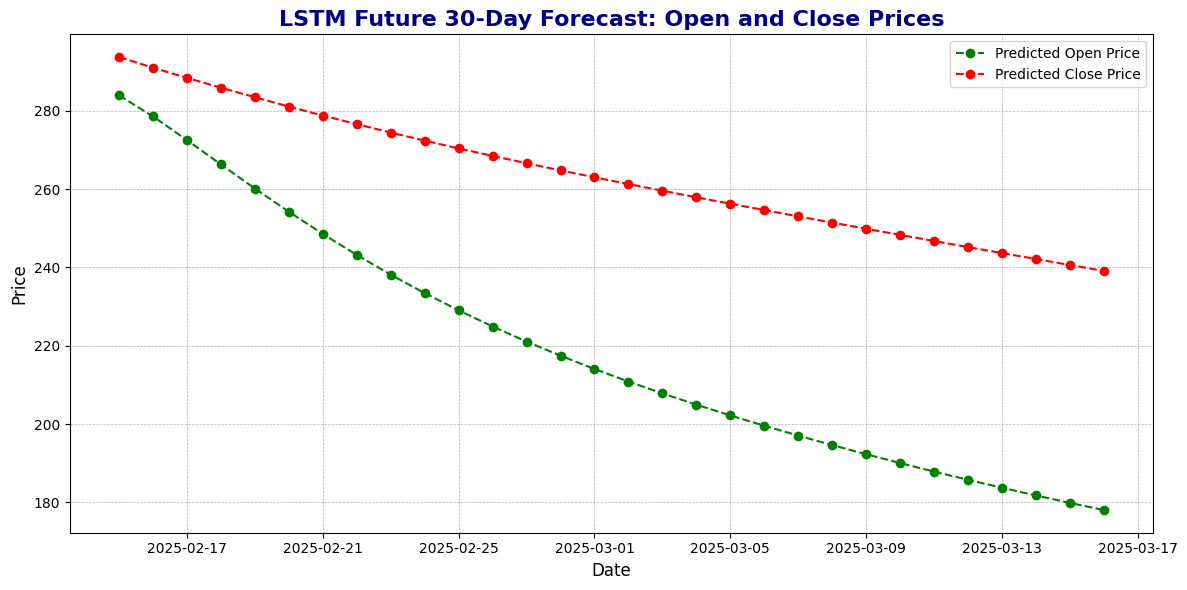

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(future_df['Date'], future_df['Predicted Open'], label='Predicted Open Price', linestyle='--', marker='o', color='green')
plt.plot(future_df['Date'], future_df['Predicted Close'], label='Predicted Close Price', linestyle='--', marker='o', color='red')
plt.title('LSTM Future 30-Day Forecast: Open and Close Prices', fontsize=16, color='navy', weight='bold')
plt.xlabel('Date', fontsize=12, color='k')
plt.ylabel('Price', fontsize=12, color='k')
plt.legend(frameon=True, loc='upper right', fontsize=10)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



# Evaluate Test Performance and Plot Actual vs Predicted for Close Price for LSTM


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Close Price Model Evaluation Metrics:
MSE: 32.8811
RMSE: 5.7342
MAE: 4.5323
R²: 0.9858


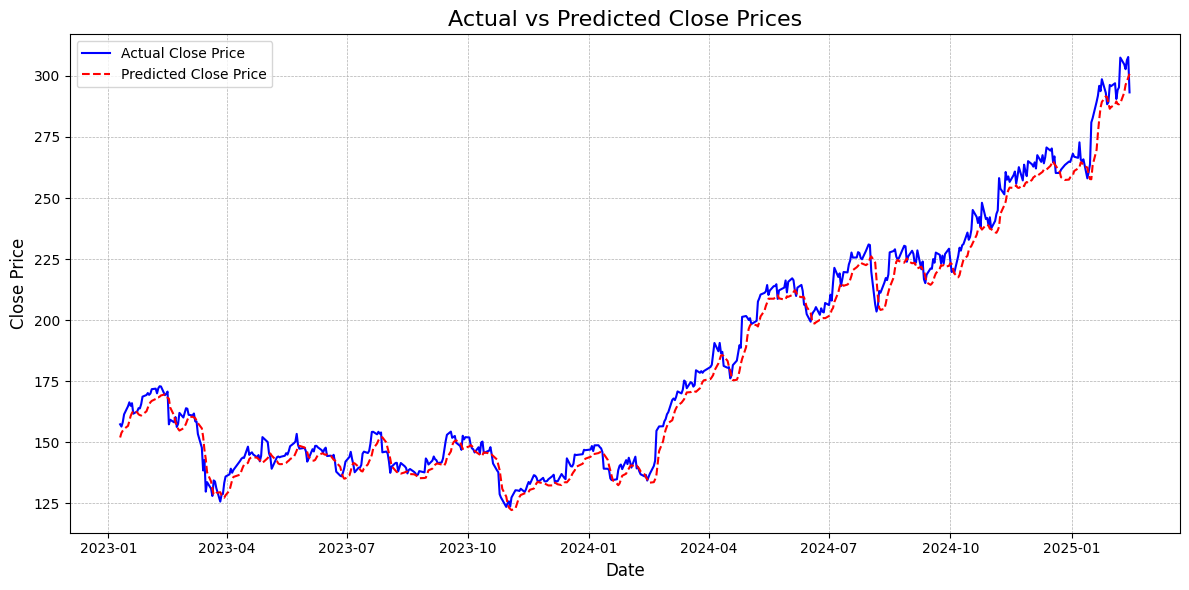

In [ ]:

Y_test_close_actual = scaler_close.inverse_transform(Y_test_close.reshape(-1, 1))
lstm_test_predictions_close = lstm_model_close.predict(X_test_close)
lstm_test_predictions_close = scaler_close.inverse_transform(lstm_test_predictions_close)

close_mse = mean_squared_error(Y_test_close_actual, lstm_test_predictions_close)
close_rmse = np.sqrt(close_mse)
close_mae = mean_absolute_error(Y_test_close_actual, lstm_test_predictions_close)
close_r2 = r2_score(Y_test_close_actual, lstm_test_predictions_close)

print("\nClose Price Model Evaluation Metrics:")
print(f"MSE: {close_mse:.4f}")
print(f"RMSE: {close_rmse:.4f}")
print(f"MAE: {close_mae:.4f}")
print(f"R²: {close_r2:.4f}")

# Get the dates from the index of the original data corresponding to the test data
dates_test_close = barclays_data.index[train_size_close + time_step + 1:train_size_close + time_step + 1 + len(Y_test_close)]


plt.figure(figsize=(12,6))
plt.plot(dates_test_close, Y_test_close_actual, label='Actual Close Price', color='blue')
plt.plot(dates_test_close, lstm_test_predictions_close, label='Predicted Close Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Close Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Evaluate Test Performance and Plot Actual vs Predicted for Open Price for LSTM


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Open Price Model Evaluation Metrics:
MSE: 73.9226
RMSE: 8.5978
MAE: 6.5033
R²: 0.9677


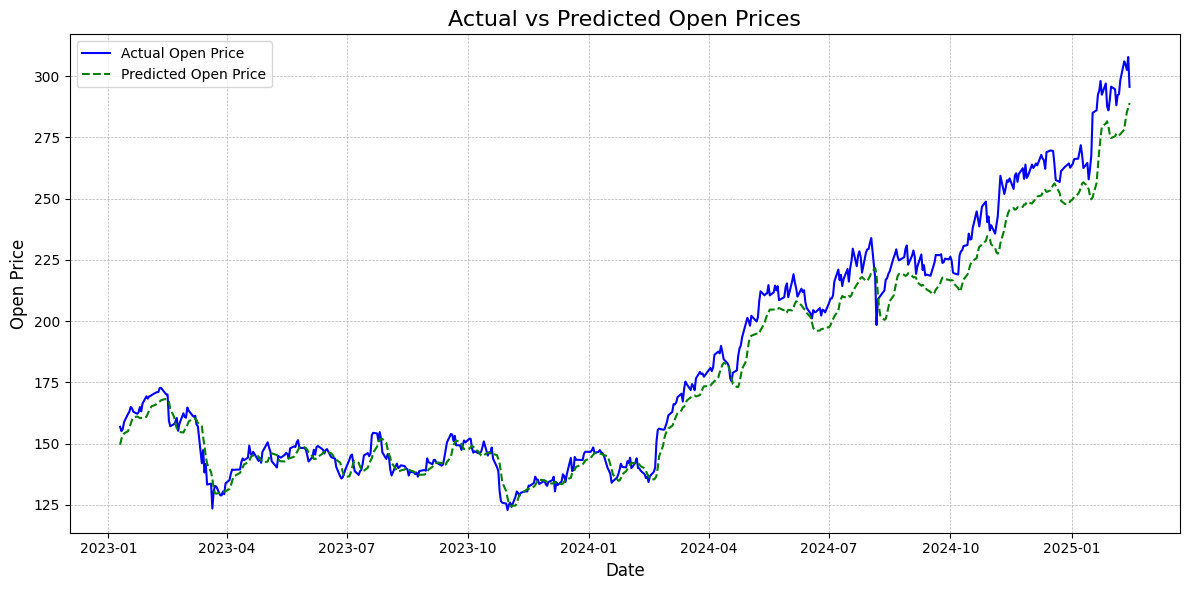

In [ ]:

Y_test_open_actual = scaler_open.inverse_transform(Y_test_open.reshape(-1, 1))
lstm_test_predictions_open = lstm_model_open.predict(X_test_open)
lstm_test_predictions_open = scaler_open.inverse_transform(lstm_test_predictions_open)

open_mse = mean_squared_error(Y_test_open_actual, lstm_test_predictions_open)
open_rmse = np.sqrt(open_mse)
open_mae = mean_absolute_error(Y_test_open_actual, lstm_test_predictions_open)
open_r2 = r2_score(Y_test_open_actual, lstm_test_predictions_open)

print("\nOpen Price Model Evaluation Metrics:")
print(f"MSE: {open_mse:.4f}")
print(f"RMSE: {open_rmse:.4f}")
print(f"MAE: {open_mae:.4f}")
print(f"R²: {open_r2:.4f}")

# Get the dates from the index of the original data corresponding to the test data
# Define dates_test_open similar to dates_test_close
dates_test_open = barclays_data.index[train_size_open + time_step + 1:train_size_open + time_step + 1 + len(Y_test_open)]


plt.figure(figsize=(12,6))
plt.plot(dates_test_open, Y_test_open_actual, label='Actual Open Price', color='blue')
plt.plot(dates_test_open, lstm_test_predictions_open, label='Predicted Open Price', color='green', linestyle='--')
plt.title('Actual vs Predicted Open Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Open Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()